# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [41]:
# 📌 Step 1: Initialize the Liquidity Pools with Separate Reserves for X and Y
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initial reserves for token pairs (A, X) and (A, Y)
R_A_X = 500  # Reserve of A for X pool
R_A_Y = 500  # Reserve of A for Y pool
R_X = 500     # Reserve of X
R_Y = 500     # Reserve of Y

# Constant product invariants for Uniswap V2
k_X = R_A_X * R_X  # Invariant for (A, X) pool
k_Y = R_A_Y * R_Y  # Invariant for (A, Y) pool

# Initial Prices
p_X = R_A_X / R_X  # Price of X in terms of A
p_Y = R_A_Y / R_Y  # Price of Y in terms of A

print(f"Initial Prices: p_X = {p_X:.4f}, p_Y = {p_Y:.4f}")
print(f"Initial Invariants: k_X = {k_X}, k_Y = {k_Y}")

Initial Prices: p_X = 1.0000, p_Y = 1.0000
Initial Invariants: k_X = 250000, k_Y = 250000


In [33]:
# 📌 Step 2: Define Swap Functions for A -> X and A -> Y with Separate Reserves

def swap_A_for_X(delta_A, R_A_X, R_X, k_X, fee_multiplier = 0.99):
    """
    Swap function: Exchanging A for X using Uniswap V2 formula with separate A reserves.
    """
    delta_A_effective = delta_A * fee_multiplier
    new_R_X = k_X / (R_A_X + delta_A_effective)
    delta_X = R_X - new_R_X
    return delta_X, new_R_X

def swap_A_for_Y(delta_A, R_A_Y, R_Y, k_Y, fee_multiplier = 0.99):
    """
    Swap function: Exchanging A for Y using Uniswap V2 formula with separate A reserves.
    """
    delta_A_effective = delta_A * fee_multiplier  # Apply the fee
    new_R_Y = k_Y / (R_A_Y + delta_A_effective)  # Solve for new R_Y
    delta_Y = R_Y - new_R_Y  # Amount of Y received
    return delta_Y, new_R_Y


In [4]:
# 📌 Step 3: Arbitrage Condition Check

def arbitrage_check(p_X, p_Y):
    """
    Checks if arbitrage is possible:
    - If p_X + p_Y > 1, merge X & Y into A.
    - If p_X + p_Y < 1, split A into X & Y.
    - Otherwise, equilibrium is maintained.
    """
    if p_X + p_Y > 1:
        return "Merge X & Y into A"
    elif p_X + p_Y < 1:
        return "Split A into X & Y"
    else:
        return "Equilibrium"


In [48]:
def update_prices():
    """
    Update prices of X and Y after swaps.
    """
    new_p_X = R_A_X / R_X  # Updated price of X
    new_p_Y = R_A_Y / R_Y  # Updated price of Y

    return new_p_X, new_p_Y

#     def swap_A_for_Y(self, delta_A, fee_multiplier=0.99):
#         """
#         Swap 'delta_A' of external A for Y in the (A, Y) pool.
#         """
#         delta_A_effective = delta_A * fee_multiplier
#         new_R_Y = self.k_Y / (self.R_A_Y + delta_A_effective)
#         delta_Y = self.R_Y - new_R_Y
#
#         self.R_A_Y += delta_A
#         self.R_Y = new_R_Y
#
#         print(f"User received {delta_Y:.4f} Y. And platform received {delta_Y:.4f} X.")
#         print(f"Platform paid {delta_Y - delta_A:.4f} A.")
#         self.external_X += delta_Y
#         self.external_A -= delta_Y - delta_A
#
#         self.p_Y = self.R_A_Y / self.R_Y
#
#         print(f"[swap_A_for_Y] Swapped {delta_A:.4f} A for {delta_Y:.4f} Y (fee {1-fee_multiplier:.2%}).")
#         self.log_state()
#         # self.arbitrage_action()
#         return delta_Y
#
#     def swap_X_for_A(self, delta_X, fee_multiplier=0.99):
#         """
#         Swap 'delta_X' of external X for A in the (A, X) pool.
#         """
#         if delta_X > self.external_X:
#             raise ValueError("Not enough X in external wallet to swap.")
#
#         delta_X_effective = delta_X * fee_multiplier
#         new_R_A_X = self.k_X / (self.R_X + delta_X_effective)
#         delta_A = self.R_A_X - new_R_A_X
#
#         self.R_X += delta_X
#         self.R_A_X = new_R_A_X
#
#         self.external_X -= delta_X
#         self.external_A += delta_A
#
#         self.p_X = self.R_A_X / self.R_X
#
#         print(f"[swap_X_for_A] Swapped {delta_X:.4f} X for {delta_A:.4f} A (fee {1-fee_multiplier:.2%}).")
#         self.log_state()
#         self.arbitrage_action()
#         return delta_A
#
#
#     def arbitrage_action(self):
#         """
#         After each swap, automatically check if p_X + p_Y > 1 (merge) or < 1 (split).
#         If so, perform a small 'merge' or 'split' using some external assets to capture arbitrage.
#         """
#         total_price = self.p_X + self.p_Y
#
#         if total_price > 1.000001:
#             print("[arbitrage_action] p_X + p_Y > 1 => Attempt MERGE (sell external X,Y for A).")
#             self.do_merge()
#         elif total_price < 0.999999:
#             print("[arbitrage_action] p_X + p_Y < 1 => Attempt SPLIT (buy X,Y with external A).")
#             self.do_split()
#         else:
#             print("[arbitrage_action] No significant arbitrage. (p_X + p_Y ~ 1)")
#
#     def do_merge(self, fee_multiplier=0.99):
#         """
#         Merge: Sell any external X and Y we hold for A.
#         This should push p_X + p_Y downward, closer to 1.
#         """
#         if self.external_X <= 0 and self.external_Y <= 0:
#             print("  Nothing to merge; no external X or Y.")
#             return
#
#         if self.external_X > 0:
#             self.swap_X_for_A(self.external_X, fee_multiplier=fee_multiplier)
#
#         if self.external_Y > 0:
#             self.swap_Y_for_A(self.external_Y, fee_multiplier=fee_multiplier)
#
#     def do_split(self, fee_multiplier=0.99):
#         """
#         Split: Use some of our external A to buy X and Y.
#         This should push p_X + p_Y upward, closer to 1.
#
#         For demonstration, we do a partial split (say 25% of our external A).
#         """
#         if self.external_A <= 0:
#             print("Nothing to split; no external A.")
#             return
#
#         amount_to_split = self.external_A * 0.25
#         half_split = amount_to_split / 2
#
#         self.swap_A_for_X(half_split, fee_multiplier=fee_multiplier)
#         self.swap_A_for_Y(half_split, fee_multiplier=fee_multiplier)
#

# Idea

## Question 1

Q: The user came to us with X amount of A. Depending on which price do we need to calculate his reward?

A:
Option 1: The outcome of curve where initial price is set to the 0.5 between X/Y and A



In [214]:
class UniswapV2:
    def __init__(self, initial_balance):
        """
        Initialize the model with a single parameter: total initial A balance.
        """

        arbitrage_balance = int(initial_balance * 0.2)
        invest_balance = initial_balance - arbitrage_balance

        balance_for_split = int(invest_balance * 0.5)
        balance_for_reserve = invest_balance - balance_for_split

        self.R_X, self.R_Y = balance_for_split, balance_for_split

        self.R_A_X = balance_for_reserve // 2
        self.R_A_Y = balance_for_reserve // 2

        self.k_X = self.R_A_X * self.R_X
        self.k_Y = self.R_A_Y * self.R_Y

        self.external_A = arbitrage_balance
        self.external_X = 0
        self.external_Y = 0

        self.p_X = self.R_A_X / self.R_X
        self.p_Y = self.R_A_Y / self.R_Y

        print("=== Initialized UniswapV2 Pools ===")
        self.log_state()
        print("====================================\n")

    def buy_X(self, amount, fee_multiplier=0.99):
        """
        Buy 'amount' of X using external A.
        """
        possible_Y = (amount / self.p_Y) * fee_multiplier
        actual_out_A = self.R_A_Y - self.k_Y / (self.R_Y + possible_Y)

        self.R_A_Y -= actual_out_A
        self.R_Y += actual_out_A + amount
        self.p_Y = self.R_A_Y / self.R_Y

        new_R_X = self.R_A_X / (1 - self.p_Y)
        self.external_X += self.R_X - new_R_X
        self.R_X = new_R_X
        self.p_X = self.R_A_X / self.R_X

        print(f"User received {amount} X.")

        self.k_Y = self.R_A_Y * self.R_Y
        self.k_X = self.R_A_X * self.R_X

        self.log_state()

        return actual_out_A + amount

    def buy_Y(self, amount, fee_multiplier=0.99):
        """
        Buy 'amount' of Y using external A.
        """
        possible_X = (amount / self.p_X) * fee_multiplier
        actual_out_A = self.R_A_X - self.k_X / (self.R_X + possible_X)

        self.R_A_X -= actual_out_A
        self.R_X += actual_out_A + amount
        self.p_X = self.R_A_X / self.R_X

        new_R_Y = self.R_A_Y / (1 - self.p_X)
        self.external_Y += self.R_Y - new_R_Y
        self.R_Y = new_R_Y
        self.p_Y = self.R_A_Y / self.R_Y

        print(f"User received {amount} Y.")

        self.k_Y = self.R_A_Y * self.R_Y
        self.k_X = self.R_A_X * self.R_X

        self.reinvest()

        self.log_state()

        return actual_out_A + amount

    def reinvest(self):
        if self.external_X > 0 and self.external_Y > 0:
            to_reinvest = min(self.external_X, self.external_Y)
            print(f"Splitted {to_reinvest} X and Y into A.")

            self.external_X -= to_reinvest
            self.external_Y -= to_reinvest
            self.external_A += to_reinvest

        if self.external_X > 0 and self.external_A > 0:
            max_possible_r_a_x = self.p_X * self.external_X

            actual_r_a_x = min(max_possible_r_a_x, self.external_A)
            actual_r_x = actual_r_a_x / self.p_X

            self.R_A_X += actual_r_a_x
            self.R_X += actual_r_x

            self.external_A -= actual_r_a_x
            self.external_X -= actual_r_x

            self.k_X = self.R_A_X * self.R_X
            self.p_X = self.R_A_X / self.R_X

        if self.external_Y > 0 and self.external_A > 0:
            max_possible_r_a_y = self.p_Y * self.external_Y

            actual_r_a_y = min(max_possible_r_a_y, self.external_A)
            actual_r_y = actual_r_a_y / self.p_Y

            self.external_A -= actual_r_a_y
            self.external_Y -= actual_r_y

            self.R_A_Y += actual_r_a_y
            self.R_Y += actual_r_y

            self.k_Y = self.R_A_Y * self.R_Y
            self.p_Y = self.R_A_Y / self.R_Y


    def log_state(self):
        """
        Prints the current on-chain reserves and the derived prices p_X, p_Y.
        Also prints what's in the external wallet for clarity.
        """
        print("Current Pool State:")
        print(f"  (A, X) Pool => R_A_X={self.R_A_X:.4f}, R_X={self.R_X:.4f}, p_X={self.p_X:.4f}")
        print(f"  (A, Y) Pool => R_A_Y={self.R_A_Y:.4f}, R_Y={self.R_Y:.4f}, p_Y={self.p_Y:.4f}")
        print(f"  => p_X + p_Y = {self.p_X + self.p_Y:.6f}")
        print(f"External Wallet => A={self.external_A:.4f}, X={self.external_X:.4f}, Y={self.external_Y:.4f}")
        total_A_amount = self.external_A + self.R_A_X + self.R_A_Y + min(self.R_X + self.external_X, self.R_Y + self.external_Y)

        x_wins = self.external_A + self.R_A_X + self.R_A_Y + self.R_X + self.external_X
        y_wins = self.external_A + self.R_A_X + self.R_A_Y + self.R_Y + self.external_Y

        print(f"If X wins: {x_wins:.4f}")
        print(f"If Y wins: {y_wins:.4f}")

        print(f"Total A amount: {total_A_amount:.4f}")
        print("")

In [227]:
model = UniswapV2(500_000)
model.buy_Y(15_000)

=== Initialized UniswapV2 Pools ===
Current Pool State:
  (A, X) Pool => R_A_X=100000.0000, R_X=200000.0000, p_X=0.5000
  (A, Y) Pool => R_A_Y=100000.0000, R_Y=200000.0000, p_Y=0.5000
  => p_X + p_Y = 1.000000
External Wallet => A=100000.0000, X=0.0000, Y=0.0000
If X wins: 500000.0000
If Y wins: 500000.0000
Total A amount: 500000.0000


User received 15000 Y.
Current Pool State:
  (A, X) Pool => R_A_X=87070.0914, R_X=227929.9086, p_X=0.3820
  (A, Y) Pool => R_A_Y=123599.2398, R_Y=200000.0000, p_Y=0.6180
  => p_X + p_Y = 1.000000
External Wallet => A=76400.7602, X=0.0000, Y=0.0000
If X wins: 515000.0000
If Y wins: 487070.0914
Total A amount: 487070.0914



27929.908576404006

In [225]:
model.buy_X(15_000)

User received 15000 X.
Current Pool State:
  (A, X) Pool => R_A_X=20049.0203, R_X=48540.8220, p_X=0.4130
  (A, Y) Pool => R_A_Y=135976.7982, R_Y=231660.5185, p_Y=0.5870
  => p_X + p_Y = 1.000000
External Wallet => A=89781.3005, X=257187.5150, Y=0.0000
If X wins: 551535.4560
If Y wins: 477467.6375
Total A amount: 477467.6375



28508.090796828532

In [230]:
model.buy_Y(15_000)

User received 15000 Y.
Current Pool State:
  (A, X) Pool => R_A_X=50024.3910, R_X=309975.6090, p_X=0.1614
  (A, Y) Pool => R_A_Y=167723.6598, R_Y=200000.0000, p_Y=0.8386
  => p_X + p_Y = 1.000000
External Wallet => A=32276.3402, X=0.0000, Y=0.0000
If X wins: 560000.0000
If Y wins: 450024.3910
Total A amount: 450024.3910



26980.67043625644

In [15]:
# 📌 Step 4: Simulate Market Dynamics with Different Trade Sizes and Separate Reserves

trade_sizes = np.linspace(10, 100, 10)  # Trade sizes from 10 to 100 A

results = []
for delta_A in trade_sizes:
    delta_X, new_R_X = swap_A_for_X(delta_A, R_A_X, R_X, k_X)
    delta_Y, new_R_Y = swap_A_for_Y(delta_A, R_A_Y, R_Y, k_Y)

    new_p_X = R_A_X / new_R_X  # Updated price of X
    new_p_Y = R_A_Y / new_R_Y  # Updated price of Y
    arb_action = arbitrage_check(new_p_X, new_p_Y)

    results.append({
        "Delta A": delta_A,
        "Delta X Out": delta_X,
        "Delta Y Out": delta_Y,
        "New Price X": new_p_X,
        "New Price Y": new_p_Y,
        "Arbitrage Action": arb_action
    })

# Convert results to a DataFrame for easy viewing
df = pd.DataFrame(results)
df


,Delta A,Delta X Out,Delta Y Out,New Price X,New Price Y,Arbitrage Action
0,10.0,9.775085,9.775085,1.01994,1.01994,Merge X & Y into A
1,20.0,19.175289,19.175289,1.03988,1.03988,Merge X & Y into A
2,30.0,28.221774,28.221774,1.05982,1.05982,Merge X & Y into A
3,40.0,36.934134,36.934134,1.07976,1.07976,Merge X & Y into A
4,50.0,45.330545,45.330545,1.09970,1.09970,Merge X & Y into A
5,60.0,53.427888,53.427888,1.11964,1.11964,Merge X & Y into A
6,70.0,61.241861,61.241861,1.13958,1.13958,Merge X & Y into A
7,80.0,68.787084,68.787084,1.15952,1.15952,Merge X & Y into A
8,90.0,76.077188,76.077188,1.17946,1.17946,Merge X & Y into A
9,100.0,83.124896,83.124896,1.19940,1.19940,Merge X & Y into A


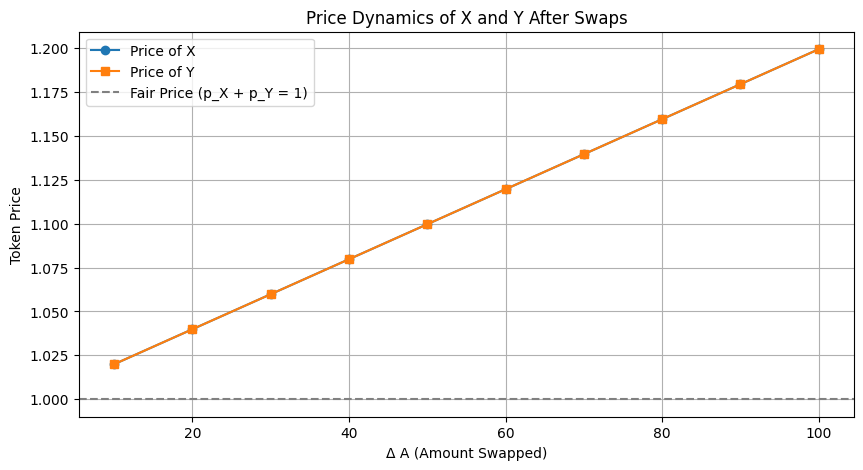

In [16]:
# 📌 Step 5: Visualize the Market Simulation Results

plt.figure(figsize=(10, 5))
plt.plot(df["Delta A"], df["New Price X"], label="Price of X", marker="o")
plt.plot(df["Delta A"], df["New Price Y"], label="Price of Y", marker="s")
plt.axhline(1, color='gray', linestyle='--', label="Fair Price (p_X + p_Y = 1)")
plt.xlabel("Δ A (Amount Swapped)")
plt.ylabel("Token Price")
plt.title("Price Dynamics of X and Y After Swaps")
plt.legend()
plt.grid()
plt.show()
